<a href="https://colab.research.google.com/github/muffin-head/netflixReccommendationEngine/blob/main/netflixReccommendationEngine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib
matplotlib.use('nbagg')
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.max_open_warning':0})
import seaborn as sns
sns.set_style('whitegrid')
import os
from scipy import sparse
from scipy.sparse import csr_matrix
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
import random

In [2]:
!pip install scikit-learn

Defaulting to user installation because normal site-packages is not writeable

DEPRECATION: Loading egg at c:\program files\python311\lib\site-packages\vboxapi-1.0-py3.11.egg is deprecated. pip 23.3 will enforce this behaviour change. A possible replacement is to use pip for package installation..

[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip



  Obtaining dependency information for scikit-learn from https://files.pythonhosted.org/packages/a8/e9/3e4879974a7c4dcaca2a746dde3df08d0ae8f14c74b03591616ce5f0a8b1/scikit_learn-1.4.0-1-cp311-cp311-win_amd64.whl.metadata
  Obtaining dependency information for joblib>=1.2.0 from https://files.pythonhosted.org/packages/10/40/d551139c85db202f1f384ba8bcf96aca2f329440a844f924c8a0040b6d02/joblib-1.3.2-py3-none-any.whl.metadata
  Obtaining dependency information for threadpoolctl>=2.0.0 from https://files.pythonhosted.org/packages/81/12/fd4dea011af9d69e1cad05c75f3f7202cdcbeac9b712eea58ca779a72865/threadpoolctl-3.2.0-py3-none-any.whl.metadata
   ---------------------------------------- 0.0/10.6 MB ? eta -:--:--
   --- ------------------------------------ 0.8/10.6 MB 17.8 MB/s eta 0:00:01
   ------- -------------------------------- 1.9/10.6 MB 20.5 MB/s eta 0:00:01
   ----------- ---------------------------- 3.0/10.6 MB 21.2 MB/s eta 0:00:01
   -------------- ------------------------- 3.9/10.6 

In [4]:
from google.colab import drive
drive.mount('drive')

ModuleNotFoundError: No module named 'google.colab'

In [7]:
start = datetime.now()

# Create a file 'data.csv' before reading it
# Read all the files in netflix and store them in one big file('data.csv')
# We re reading from each of the four files and appendig each rating to a global file 'train.csv'
data = open('data.csv', mode='w')

row = list()
files=["C:/study/Case Study 9/archive/combined_data_1.txt","C:/study/Case Study 9/archive/combined_data_2.txt","C:/study/Case Study 9/archive/combined_data_3.txt","C:/study/Case Study 9/archive/combined_data_4.txt"]

for file in files:
    print("Reading ratings from {}...".format(file))
    with open(file) as f:
        for line in f:
            line = line.strip()
            if line.endswith(':'):
                # All below are ratings for this movie, until another movie appears.
                movie_id = line.replace(':', '')
            else:
                row = [x for x in line.split(',')]
                row.insert(0, movie_id)
                data.write(','.join(row))
                data.write('\n')
    print("Done.\n")
data.close()
print('Time taken :', datetime.now() - start)

Reading ratings from C:/study/Case Study 9/archive/combined_data_1.txt...
Done.

Reading ratings from C:/study/Case Study 9/archive/combined_data_2.txt...
Done.

Reading ratings from C:/study/Case Study 9/archive/combined_data_3.txt...
Done.

Reading ratings from C:/study/Case Study 9/archive/combined_data_4.txt...
Done.

Time taken : 0:05:56.922574


In [8]:
dataframe=pd.read_csv('data.csv',sep=',',names=['movie','user','rating','date'])



In [9]:
dataframe.date=pd.to_datetime(dataframe.date)
dataframe.sort_values(by='date', inplace=True)


In [10]:
print(sum(dataframe.isnull().any()))
print(dataframe.duplicated(['movie','user','rating','date']))
np.unique(dataframe['movie'])
np.unique(dataframe['user'])
np.unique(dataframe['date'])
print(dataframe.shape[0])

0
56431994    False
9056171     False
58698779    False
48101611    False
81893208    False
            ...  
49939086    False
42072268    False
47098649    False
55621336    False
25464092    False
Length: 100480507, dtype: bool
100480507


In [11]:

if not os.path.isfile('train.csv'):
  dataframe.iloc[:int(dataframe.shape[0]*0.80)].to_csv('train.csv',index=False)
if not os.path.isfile('test.csv'):
  dataframe.iloc[int(dataframe.shape[0]* 0.80):].to_csv('test.csv',index=False)

In [13]:
train_df=pd.read_csv('train.csv',parse_dates=['date'])
test_df=pd.read_csv('test.csv')

In [14]:
train_df.head()

,movie,user,rating,date
0,10341,510180,4,1999-11-11
1,1798,510180,5,1999-11-11
2,10774,510180,3,1999-11-11
3,8651,510180,2,1999-11-11
4,14660,510180,2,1999-11-11


In [15]:
train_df.shape

(80384405, 4)

# Find out how often rating are given by a user

In [33]:
# method to make y-axis more readable
def human(num, units = 'M'):
    units = units.lower()
    num = float(num)
    if units == 'k':
        return str(num/10**3) + " K"
    elif units == 'm':
        return str(num/10**6) + " M"
    elif units == 'b':
        return str(num/10**9) +  " B"

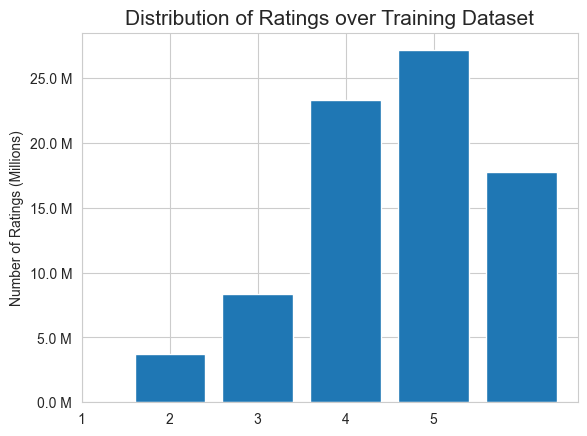

In [32]:
%matplotlib inline
import matplotlib.ticker as mticker
fig, ax = plt.subplots()
plt.title('Distribution of ratings over Training dataset', fontsize=15)
sns.countplot(train_df.rating)
y_ticks=ax.get_yticks()
ax.yaxis.set_major_locator(mticker.FixedLocator(y_ticks))
ax.set_yticklabels([human(item, 'M') for item in y_ticks ])
ax.set_ylabel('No. of Ratings(Millions)')
plt.show()

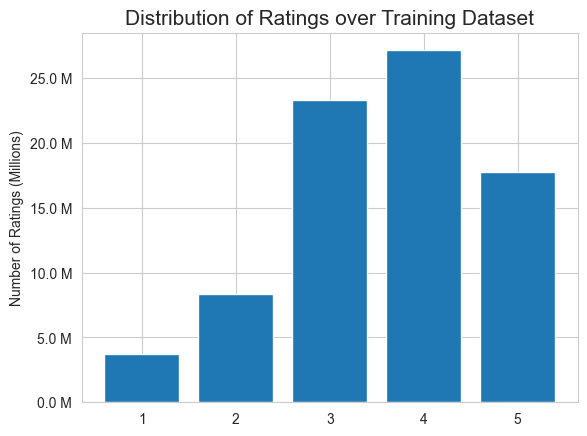

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker

# Assuming train_df is your DataFrame and it has a column 'rating'

# Calculate rating counts manually
rating_counts = train_df['rating'].value_counts().sort_index()
fig, ax = plt.subplots()
plt.title('Distribution of Ratings over Training Dataset', fontsize=15)
ax.bar(rating_counts.index, rating_counts.values)
y_ticks = ax.get_yticks()
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: human(x, 'M')))
x.set_ylabel('Number of Ratings (Millions)')
ax.set_xticks(range(1, 6))
ax.set_xticklabels([str(i) for i in range(1, 6)])

plt.show()
